In [1]:
import pandas as pd
import openpyxl
import pandas as pd
from sklearn.cluster import DBSCAN
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import adjusted_rand_score

## DBSCAN


In [2]:
noc_roma = pd.read_csv("../NOC_ROMA_202403110800-202403111600_clusters_la.csv")

In [3]:
noc_roma["correct_label"] = noc_roma["NOTE SPV"].apply(
    lambda x: 0 if "CORRELAZIONE OK" in x else 1
)

In [4]:
noc_roma["first_occurrence"] = pd.to_datetime(noc_roma["first_occurrence"])

noc_roma = noc_roma.sort_values(by=["cluster_id", "first_occurrence"])


noc_roma["tempo_di_interarrivo"] = noc_roma.groupby("cluster_id")[
    "first_occurrence"
].diff()


noc_roma["tempo_di_interarrivo"] = noc_roma["tempo_di_interarrivo"].fillna(
    pd.Timedelta(seconds=0)
)
noc_roma["tempo_di_interarrivo"] = noc_roma["tempo_di_interarrivo"].dt.total_seconds()

## Statistics


In [5]:
noc_roma_grouped = noc_roma.groupby("cluster_id")
numero_cluster = noc_roma["cluster_id"].nunique()

cluster_corretti = []
cluster_totalmente_errati = []
cluster_parzialmente_corretti = []

for cluster_id, gruppo in noc_roma.groupby("cluster_id"):
    if gruppo["NOTE SPV"].str.contains("CORRELAZIONE OK").all():
        cluster_corretti.append(cluster_id)
    elif gruppo["NOTE SPV"].str.contains("CORRELAZIONE ERRATA").all():
        cluster_totalmente_errati.append(cluster_id)
    else:
        cluster_parzialmente_corretti.append(cluster_id)

print("Numero Cluster:", numero_cluster)
print(f"Numero di cluster corretti: {len(cluster_corretti)}")
print(f"Numero di cluster totalmente errati: {len(cluster_totalmente_errati)}")
print(f"Numero di cluster parzialmente corretti: {len(cluster_parzialmente_corretti)}")

Numero Cluster: 35
Numero di cluster corretti: 13
Numero di cluster totalmente errati: 12
Numero di cluster parzialmente corretti: 10


## DBSCAN with Tempo di Interarrivo


In [6]:
cluster_labels = []
df_list = []


for cluster_id, group in noc_roma.groupby("cluster_id"):
    # Convertire i tempi in numeri
    X = group[["tempo_di_interarrivo"]]
    # Applicazione di DBSCAN
    dbscan = DBSCAN(eps=2, min_samples=2)  # eps è in secondi (86400 secondi = 1 giorno)
    labels = dbscan.fit_predict(X)
    cluster_labels.extend(labels)
    # Creazione di un DataFrame temporaneo con i risultati
    temp_df = pd.DataFrame(
        {
            "cluster_id": cluster_id,
            "CLUSTER_LABEL": labels,
        }
    )

    df_list.append(temp_df)


final_df = pd.concat(df_list, ignore_index=True)
filtered_noc_roma = noc_roma[["NOTE SPV"]]


merge_df = pd.merge(
    final_df, filtered_noc_roma, left_index=True, right_index=True, how="left"
)

c:\VirtualEnvironment\envs\TIM_thesis\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] Impossibile trovare il file specificato
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\VirtualEnvironment\envs\TIM_thesis\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\VirtualEnvironment\envs\TIM_thesis\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\VirtualEnvironment\envs\TIM_thesis\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\VirtualEnvironment\envs\TIM_thesis\Lib\subprocess.py", line 1

In [7]:
merge_grouped = merge_df.groupby("cluster_id")

reconstructed_correct_clusters = 0
for cluster_id, group in merge_grouped:

    if cluster_id in cluster_corretti:
        if group["CLUSTER_LABEL"].nunique() == 1:
            reconstructed_correct_clusters += 1

print(
    f"Numero di cluster corretti ricostruiti correttamente: {reconstructed_correct_clusters} di {len(cluster_corretti)}"
)


partially_correct_clusters_predicted = 0

for cluster_id, group in merge_grouped:

    if cluster_id in cluster_parzialmente_corretti:
        # Filtra gli allarmi con "CORRELAZIONE OK"
        allarmi_ok = group[group["NOTE SPV"].str.contains("CORRELAZIONE OK")]
        # Filtra gli allarmi con "CORRELAZIONE ERRATA"
        allarmi_errata = group[group["NOTE SPV"].str.contains("CORRELAZIONE ERRATA")]

        # Verifica che tutti gli allarmi OK abbiano la stessa label
        label_unica_ok = allarmi_ok["CLUSTER_LABEL"].nunique() == 1

        # Verifica che gli allarmi ERRATA abbiano una label diversa da quella degli allarmi OK
        if not allarmi_errata.empty and label_unica_ok:
            label_ok = allarmi_ok["CLUSTER_LABEL"].iloc[0]
            # Verifica che tutte le label ERRATA siano diverse da quella OK
            label_diverse_errata = (
                not allarmi_errata["CLUSTER_LABEL"].isin([label_ok]).any()
            )

            if label_diverse_errata:
                partially_correct_clusters_predicted += 1

print(
    f"Numero di cluster corretti ricostruiti correttamente: {partially_correct_clusters_predicted} di {len(cluster_parzialmente_corretti)}"
)

merge_df.to_excel("DBSCAN_df_interarrivo.xlsx", index=False)

Numero di cluster corretti ricostruiti correttamente: 4 di 13
Numero di cluster corretti ricostruiti correttamente: 1 di 10


Valori di epsilon : 100%|██████████| 4000/4000 [24:48<00:00,  2.69it/s]


reconstructed_correct_clusters_values [ 5  5  5 ... 11 11 11]
cluster_corretti_values [13 13 13 ... 13 13 13]


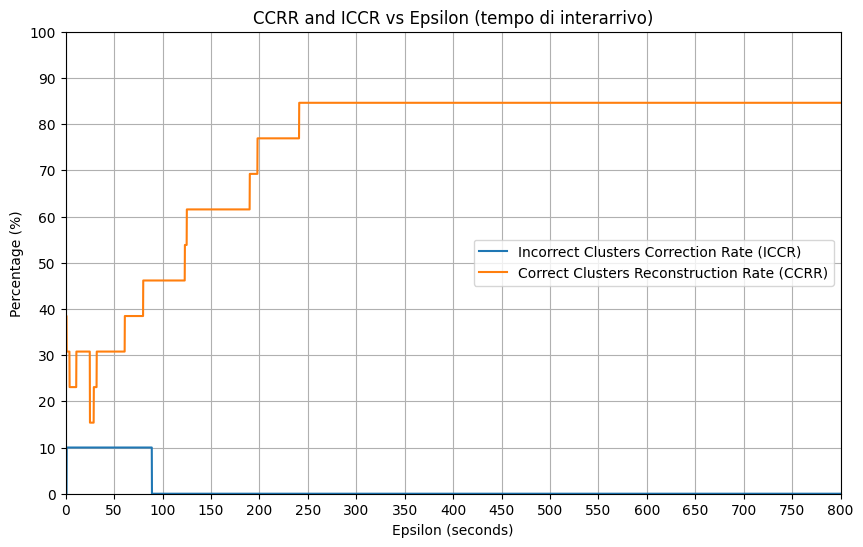

In [12]:
epsilon_values = np.arange(0.1, 800, 0.2)


results = []
ari_scores = []
reconstructed_correct_clusters_values = []
average_ari_scores_values = []
partially_correct_clusters_predicted_values = []
cluster_corretti_values = []
cluster_parzialmente_corretti_values = []

for epsilon in tqdm(epsilon_values, desc="Valori di epsilon "):
    cluster_labels = []
    df_list = []

    for cluster_id, group in noc_roma.groupby("cluster_id"):
        # Convertire i tempi in numeri
        X = group[["tempo_di_interarrivo"]]

        # Applicazione di DBSCAN con epsilon variabile
        dbscan = DBSCAN(eps=epsilon, min_samples=2)  # eps è in secondi
        labels = dbscan.fit_predict(X)
        true_labels_for_group = group["correct_label"].values
        if cluster_id not in cluster_totalmente_errati:
            ari_score = adjusted_rand_score(true_labels_for_group, labels)
            ari_scores.append(ari_score)
        # Creazione di un DataFrame temporaneo con i risultati
        temp_df = pd.DataFrame(
            {
                "cluster_id": cluster_id,
                "CLUSTER_LABEL": labels,
            }
        )
        df_list.append(temp_df)

    average_ari_scores_values.append(np.mean(ari_scores))
    final_df = pd.concat(df_list, ignore_index=True)
    filtered_noc_roma = noc_roma[["NOTE SPV"]]

    merge_df = pd.merge(
        final_df, filtered_noc_roma, left_index=True, right_index=True, how="left"
    )

    merge_grouped = merge_df.groupby("cluster_id")

    reconstructed_correct_clusters = 0
    for cluster_id, group in merge_grouped:

        if cluster_id in cluster_corretti:
            if group["CLUSTER_LABEL"].nunique() == 1:
                reconstructed_correct_clusters += 1

    reconstructed_correct_clusters_values.append(reconstructed_correct_clusters)
    cluster_corretti_values.append(len(cluster_corretti))

    partially_correct_clusters_predicted = 0

    for cluster_id, group in merge_grouped:

        if cluster_id in cluster_parzialmente_corretti:
            if cluster_id in cluster_parzialmente_corretti:
                # Filtra gli allarmi con "CORRELAZIONE OK"
                allarmi_ok = group[group["NOTE SPV"].str.contains("CORRELAZIONE OK")]
                # Filtra gli allarmi con "CORRELAZIONE ERRATA"
                allarmi_errata = group[
                    group["NOTE SPV"].str.contains("CORRELAZIONE ERRATA")
                ]

                # Verifica che tutti gli allarmi OK abbiano la stessa label
                label_unica_ok = allarmi_ok["CLUSTER_LABEL"].nunique() == 1

                # Verifica che gli allarmi ERRATA abbiano una label diversa da quella degli allarmi OK
                if not allarmi_errata.empty and label_unica_ok:
                    label_ok = allarmi_ok["CLUSTER_LABEL"].iloc[0]
                    # Verifica che tutte le label ERRATA siano diverse da quella OK
                    label_diverse_errata = (
                        not allarmi_errata["CLUSTER_LABEL"].isin([label_ok]).any()
                    )

                    if label_diverse_errata:
                        partially_correct_clusters_predicted += 1
    partially_correct_clusters_predicted_values.append(
        partially_correct_clusters_predicted
    )
    cluster_parzialmente_corretti_values.append(len(cluster_parzialmente_corretti))


plt.figure(figsize=(10, 6))


reconstructed_correct_clusters_values = np.array(reconstructed_correct_clusters_values)
cluster_corretti_values = np.array(cluster_corretti_values)
partially_correct_clusters_predicted_values = np.array(partially_correct_clusters_predicted_values)
cluster_parzialmente_corretti_values = np.array(cluster_parzialmente_corretti_values)

print("reconstructed_correct_clusters_values", reconstructed_correct_clusters_values)
print("cluster_corretti_values", cluster_corretti_values)
# Calcolo delle percentuali
cluster_corretti_percentage = reconstructed_correct_clusters_values / cluster_corretti_values * 100
cluster_parzialmente_corretti_percentage = partially_correct_clusters_predicted_values / cluster_parzialmente_corretti_values * 100

# Plot dei valori percentuali
plt.plot(
    epsilon_values,
    cluster_parzialmente_corretti_percentage,
    label="Incorrect Clusters Correction Rate (ICCR)",
)
plt.plot(
    epsilon_values,
    cluster_corretti_percentage,
    label="Correct Clusters Reconstruction Rate (CCRR)",
)

plt.xlabel("Epsilon (seconds)")
plt.ylabel("Percentage (%)")
plt.ylim(0, 100)  # Imposta i limiti dell'asse y da 0% a 100%
plt.yticks(np.arange(0, 101, 10))  # Imposta i ticks dell'asse y da 0 a 100 con passo 10
plt.xlim(0, 800)  # Imposta i limiti dell'asse x da 0 a 800
plt.xticks(np.arange(0, 801, 50))  # Imposta i ticks dell'asse x da 0 a 800 con passo 100
plt.title("CCRR and ICCR vs Epsilon (tempo di interarrivo)")
plt.legend()
plt.legend(loc='center right') 
plt.grid(True)

plt.show()

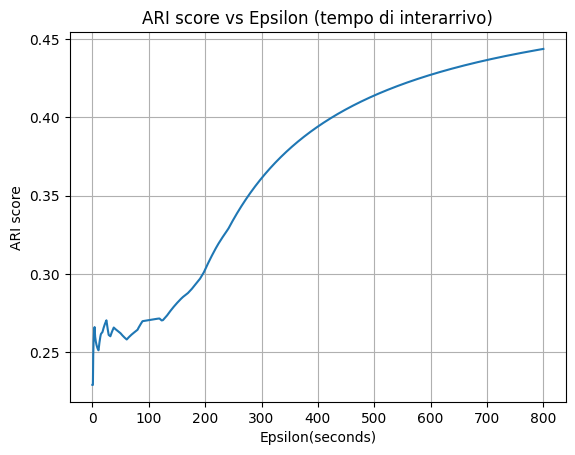

In [13]:
plt.plot(epsilon_values, average_ari_scores_values)


plt.xlabel("Epsilon(seconds)")
plt.ylabel("ARI score")
plt.xticks(np.arange(0, 801, 100))  # Imposta i ticks dell'asse x da 0 a 800 con passo 100
plt.title("ARI score vs Epsilon (tempo di interarrivo)")
plt.grid(True)

plt.show()

{(84.61538461538461, 0.0, 266.9000000000001), (84.61538461538461, 0.0, 553.5000000000001), (84.61538461538461, 0.0, 611.1000000000001), (38.46153846153847, 10.0, 72.30000000000001), (46.15384615384615, 0.0, 107.70000000000002), (84.61538461538461, 0.0, 420.3000000000001), (84.61538461538461, 0.0, 547.3000000000002), (61.53846153846154, 0.0, 131.50000000000003), (84.61538461538461, 0.0, 351.9000000000001), (84.61538461538461, 0.0, 409.5000000000001), (84.61538461538461, 0.0, 340.1000000000001), (84.61538461538461, 0.0, 467.10000000000014), (84.61538461538461, 0.0, 754.7000000000002), (61.53846153846154, 0.0, 178.30000000000004), (84.61538461538461, 0.0, 398.7000000000001), (84.61538461538461, 0.0, 525.7000000000002), (84.61538461538461, 0.0, 329.30000000000007), (84.61538461538461, 0.0, 456.3000000000001), (84.61538461538461, 0.0, 616.9000000000001), (61.53846153846154, 0.0, 167.50000000000003), (84.61538461538461, 0.0, 387.9000000000001), (84.61538461538461, 0.0, 674.5000000000001), (6

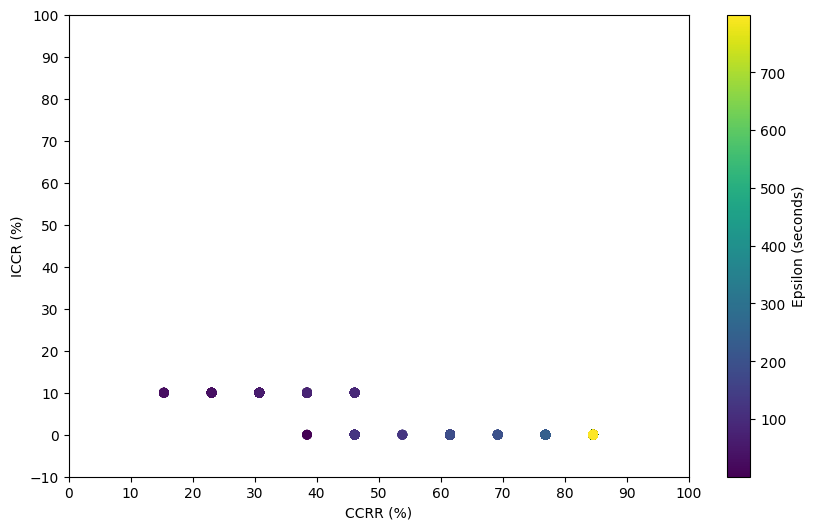

In [15]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 6))
epsilon_values = np.arange(0.1, 800, 0.2)

punti = list(
    zip(
        cluster_corretti_percentage,
        cluster_parzialmente_corretti_percentage,
        epsilon_values,
    )
)
punti = list(dict.fromkeys(punti))
distinct_points = set(punti)
print(distinct_points)
x_valori, y_valori, eps = zip(*punti)
scatter = plt.scatter(x_valori, y_valori, c=eps, cmap="viridis")

cbar = plt.colorbar(scatter)
cbar.set_label("Epsilon (seconds)")

plt.xlabel("CCRR (%)")
plt.ylabel("ICCR (%)")
plt.yticks(np.arange(-10, 101, 10))  # Imposta i ticks dell'asse y da 0 a 100 con passo 10
plt.xticks(np.arange(0, 101, 10))  # Imposta i ticks dell'asse y da 0 a 100 con passo 10
plt.show()

Coppie ottimali (CCRR, ICCR):
(84.62, 0.00)
(46.15, 10.00)


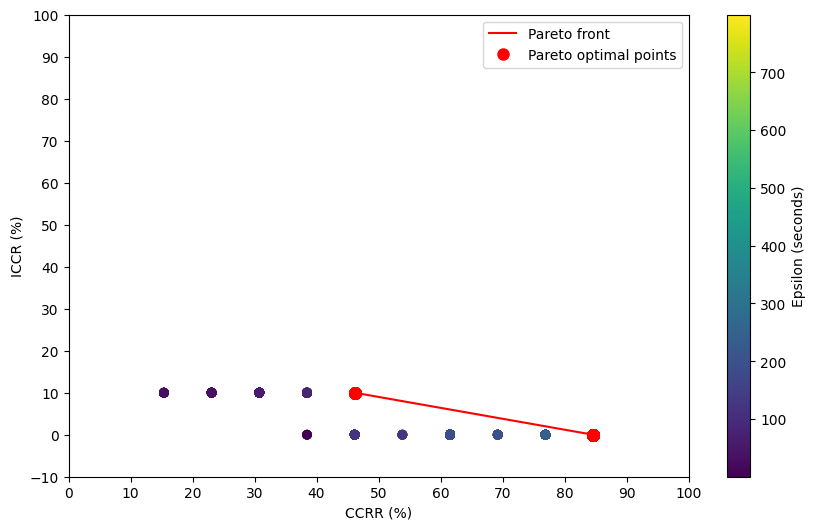

In [17]:
import oapackage

plt.figure(figsize=(10, 6))

scatter = plt.scatter(x_valori, y_valori, c=eps, cmap="viridis")

pareto = oapackage.ParetoDoubleLong()

datapoints = np.array([x_valori, y_valori])

for ii in range(0, datapoints.shape[1]):
    w = oapackage.doubleVector()
    w.push_back(float(datapoints[0, ii]))
    w.push_back(float(datapoints[1, ii]))
    pareto.addvalue(w, ii)

lst = pareto.allindices()

optimal_datapoints = datapoints[:, lst]

# Creazione di un set per le coppie ottimali
optimal_pairs_set = set()

# Aggiunta delle coppie al set
for i in lst:
    pair = (datapoints[0, i], datapoints[1, i])
    optimal_pairs_set.add(pair)

# Conversione del set in una lista
optimal_pairs = list(optimal_pairs_set)

# Stampa delle coppie ottimali
print("Coppie ottimali (CCRR, ICCR):")
for pair in optimal_pairs:
    print(f"({pair[0]:.2f}, {pair[1]:.2f})")
    
plt.plot(
    optimal_datapoints[0, :], optimal_datapoints[1, :], "r-", label="Pareto front"
)
hp = plt.plot(
    optimal_datapoints[0, :],
    optimal_datapoints[1, :],
    ".r",
    markersize=16,
    label="Pareto optimal points",
)

cbar = plt.colorbar(scatter)
cbar.set_label("Epsilon (seconds)")

plt.xlabel("CCRR (%)")
plt.ylabel("ICCR (%)")
plt.yticks(np.arange(-10, 101, 10))  # Imposta i ticks dell'asse y da 0 a 100 con passo 10
plt.xticks(np.arange(0, 101, 10))  # Imposta i ticks dell'asse y da 0 a 100 con passo 10
plt.legend()
plt.show()